In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus
import pickle
from datetime import datetime, timedelta, date
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn

In [4]:
#pickle features 
def picklefile(tofile, content):
  with open(tofile, 'wb') as f:
    pickle.dump(content, f)

In [5]:
def unpicklefile(fromfile):
  with open(fromfile, 'rb') as f:
    unpickled = pickle.load(f)
  return unpickled

In [6]:
#locate the directory with local files
%cd /content/drive/MyDrive/COVID

/content/drive/MyDrive/COVID


In [7]:
pops = pd.read_excel('Mid-2011-unformatted-syoa-data-file.xls', sheet_name = 'Mid-2011 Persons')

In [8]:
popsoa = pops.iloc[np.r_[17:95, 129:pops.shape[0]],:]

In [9]:
popsoa[' ALL AGES'].sum()

63285145

In 2011 there were 63285145 people in 406 local and unitary authorities.

In [10]:
#Bring in WICID OA:OA usual residence to place of work
OD = pd.read_csv('wu01uk_v2.csv').iloc[:,:3]
OD.columns = ["Origin", "Dest", "People"]

In [11]:
OD

,Origin,Dest,People
0,95AA,95AA,9465
1,95AA,95BB,107
2,95AA,95CC,42
3,95AA,95DD,1485
4,95AA,95EE,35
...,...,...,...
110157,W40000022,W40000018,192
110158,W40000022,W40000019,158
110159,W40000022,W40000020,303
110160,W40000022,W40000021,219


In [12]:
LAs = pd.read_csv('OAtoLA.csv')
LAs = LAs[['to_label', 'to_supplied_code']]
LAs.columns = ["Label", "Code"]
codelabdict = dict(zip(LAs["Code"], LAs["Label"]))

In [13]:
OD = OD.replace(codelabdict)

In [14]:
#replace UA as other datasets
popsoa["Name"] = popsoa["Name"].apply(lambda x: x[:-3] if x[-3:] == ' UA' else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
list(popsoa["Name"][~popsoa["Name"].isin(OD["Origin"])].drop_duplicates())

['Herefordshire',
 'Cornwall',
 'Isles of Scilly',
 'Rhondda, Cynon, Taf',
 'City of London',
 'Westminster']

In [16]:
list(OD["Origin"][~OD["Origin"].isin(popsoa["Name"])].drop_duplicates())

['Herefordshire, County of',
 'Cornwall, Isles of Scilly',
 'City of London, Westminster',
 'Rhondda Cynon Taf']

In [17]:
list(OD["Dest"][~OD["Dest"].isin(popsoa["Name"])].drop_duplicates())

['Herefordshire, County of',
 'Cornwall, Isles of Scilly',
 'City of London, Westminster',
 'OD0000001',
 'OD0000002',
 'OD0000003',
 'OD0000004',
 'Rhondda Cynon Taf']

In [18]:
# Destinations'OD0000001','OD0000002','OD0000003','OD0000004' are 
# OD0000001 = Mainly work at or from home, OD0000002 = Offshore installation, 
# OD0000003 = No fixed place, OD0000004 = Outside UK
# so these rows removed from the data
OD = OD[~OD["Dest"].isin(['OD0000001','OD0000002','OD0000003','OD0000004'])]

In [19]:
popschanges = {
  'Herefordshire': 'Herefordshire, County of',
  'Cornwall': 'Cornwall, Isles of Scilly',
  'Isles of Scilly': 'Cornwall, Isles of Scilly',
  'Rhondda, Cynon, Taf' : 'Rhondda Cynon Taf',
  'City of London': 'City of London, Westminster',
  'Westminster': 'City of London, Westminster'
}

In [20]:
popsoa = popsoa.replace(popschanges)

In [21]:
list(OD["Origin"][~OD["Origin"].isin(popsoa["Name"])].drop_duplicates())

[]

In [22]:
list(OD["Dest"][~OD["Dest"].isin(popsoa["Name"])].drop_duplicates())

[]

In [23]:
list(popsoa["Name"][~popsoa["Name"].isin(OD["Origin"])].drop_duplicates())

[]

In [24]:
popsoagrpd = popsoa.groupby(["Code", "Name"]).sum().reset_index()

In [25]:
popsoagrpd[' ALL AGES'].sum()

63285145

In [26]:
#Get the coronavirus data from gov.uk
StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]


def get_paginated_dataset(filters: FiltersType, structure: StructureType,
                          as_csv: bool = False) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json" if not as_csv else "csv"
    }

    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=60)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        if as_csv:
            csv_content = response.content.decode()

            # Removing CSV header (column names) where page 
            # number is greater than 1.
            if page_number > 1:
                data_lines = csv_content.split("\n")[1:]
                csv_content = str.join("\n", data_lines)

            data.append(csv_content.strip())
            page_number += 1
            continue

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    if not as_csv:
        return data

    # Concatenating CSV pages
    return str.join("\n", data)


if __name__ == "__main__":
    query_filters = [
        f"areaType=ltla"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "dailycases": "newCasesBySpecimenDate",
        "cumulativecases": "cumCasesBySpecimenDate",
        "dailydeaths": "newDeaths28DaysByPublishDate",
        "cumulativedeaths": "cumDeaths28DaysByPublishDate"
    }

    json_data = get_paginated_dataset(query_filters, query_structure)
    print("JSON:")
    print(f"Length:", len(json_data))
    print("Data (first 3 items):", json_data[:3])

    print("---" * 10)

JSON:
Length: 226608
Data (first 3 items): [{'date': '2021-10-24', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': None, 'cumulativecases': None, 'dailydeaths': 0, 'cumulativedeaths': 280}, {'date': '2021-10-23', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': 27, 'cumulativecases': 16380, 'dailydeaths': 2, 'cumulativedeaths': 280}, {'date': '2021-10-22', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': 50, 'cumulativecases': 16353, 'dailydeaths': 0, 'cumulativedeaths': 278}]
------------------------------


In [27]:
#change json data into data frame
covid = pd.DataFrame.from_dict(json_data)

In [28]:
covid["date"].sort_values(ascending = False)

0         2021-10-24
88230     2021-10-24
156181    2021-10-24
192159    2021-10-24
207033    2021-10-24
             ...    
8348      2020-02-03
8349      2020-02-02
8350      2020-02-01
8351      2020-01-31
8352      2020-01-30
Name: date, Length: 226608, dtype: object

In [29]:
# covid.to_csv('coviddata2021-09-28')

In [30]:
OD["Origin"][~OD["Origin"].isin(covid["name"])].drop_duplicates()

0                              Antrim
133                              Ards
275                            Armagh
402                         Ballymena
528                        Ballymoney
605                         Banbridge
942                     Carrickfergus
1050                      Castlereagh
1196                        Coleraine
1321                        Cookstown
1396                        Craigavon
1545                            Derry
1706                             Down
1840                        Dungannon
1953                        Fermanagh
2090                            Larne
2186                         Limavady
2282                          Lisburn
2462                      Magherafelt
2562                            Moyle
2640                 Newry and Mourne
2800                     Newtownabbey
2938                       North Down
3098                            Omagh
3208                         Strabane
11792                     Bournemouth
12099       

In [31]:
list(popsoa["Name"][~popsoa["Name"].isin(covid["name"])].drop_duplicates().sort_values()) == list(OD["Origin"][~OD["Origin"].isin(covid["name"])].drop_duplicates().sort_values())

True

In [32]:
covid["name"][~covid["name"].isin(popsoa["Name"])].drop_duplicates()

28695             Cornwall and Isles of Scilly
31677      Bournemouth, Christchurch and Poole
32276                                   Dorset
79327                     Folkestone and Hythe
145411                            East Suffolk
146008                            West Suffolk
146597               Somerset West and Taunton
174749              Hackney and City of London
187396                             Westminster
188003                 Antrim and Newtownabbey
188598    Armagh City, Banbridge and Craigavon
189794                Causeway Coast and Glens
190379                 Derry City and Strabane
190971                     Fermanagh and Omagh
191564                 Lisburn and Castlereagh
192159                     Mid and East Antrim
192753                              Mid Ulster
193346                  Newry, Mourne and Down
193941                     Ards and North Down
197513               Comhairle nan Eilean Siar
207033                       City of Edinburgh
220698       

In [33]:
covid["name"][~covid["name"].isin(OD["Origin"])].drop_duplicates()

28695             Cornwall and Isles of Scilly
31677      Bournemouth, Christchurch and Poole
32276                                   Dorset
79327                     Folkestone and Hythe
145411                            East Suffolk
146008                            West Suffolk
146597               Somerset West and Taunton
174749              Hackney and City of London
187396                             Westminster
188003                 Antrim and Newtownabbey
188598    Armagh City, Banbridge and Craigavon
189794                Causeway Coast and Glens
190379                 Derry City and Strabane
190971                     Fermanagh and Omagh
191564                 Lisburn and Castlereagh
192159                     Mid and East Antrim
192753                              Mid Ulster
193346                  Newry, Mourne and Down
193941                     Ards and North Down
197513               Comhairle nan Eilean Siar
207033                       City of Edinburgh
220698       

In [34]:
list(covid["name"][~covid["name"].isin(popsoagrpd["Name"])].drop_duplicates()) == list(covid["name"][~covid["name"].isin(OD["Origin"])].drop_duplicates())

True

In [35]:
list(popsoagrpd["Name"][~popsoagrpd["Name"].isin(covid["name"])].drop_duplicates().sort_values())

['Antrim',
 'Ards',
 'Armagh',
 'Ballymena',
 'Ballymoney',
 'Banbridge',
 'Bournemouth',
 'Carrickfergus',
 'Castlereagh',
 'Christchurch',
 'City of London, Westminster',
 'Coleraine',
 'Cookstown',
 'Cornwall, Isles of Scilly',
 'Craigavon',
 'Derry',
 'Down',
 'Dungannon',
 'East Dorset',
 'Edinburgh, City of',
 'Eilean Siar',
 'Fermanagh',
 'Forest Heath',
 'Hackney',
 'Larne',
 'Limavady',
 'Lisburn',
 'Magherafelt',
 'Moyle',
 'Newry and Mourne',
 'Newtownabbey',
 'North Dorset',
 'North Down',
 'Omagh',
 'Poole',
 'Purbeck',
 'Shepway',
 'St Edmundsbury',
 'Strabane',
 'Suffolk Coastal',
 'Taunton Deane',
 'The Vale of Glamorgan',
 'Waveney',
 'West Dorset',
 'West Somerset',
 'Weymouth and Portland']

In [36]:
list(covid["name"][~covid["name"].isin(popsoagrpd["Name"])].drop_duplicates().sort_values())

['Antrim and Newtownabbey',
 'Ards and North Down',
 'Armagh City, Banbridge and Craigavon',
 'Bournemouth, Christchurch and Poole',
 'Causeway Coast and Glens',
 'City of Edinburgh',
 'Comhairle nan Eilean Siar',
 'Cornwall and Isles of Scilly',
 'Derry City and Strabane',
 'Dorset',
 'East Suffolk',
 'Fermanagh and Omagh',
 'Folkestone and Hythe',
 'Hackney and City of London',
 'Lisburn and Castlereagh',
 'Mid Ulster',
 'Mid and East Antrim',
 'Newry, Mourne and Down',
 'Somerset West and Taunton',
 'Vale of Glamorgan',
 'West Suffolk',
 'Westminster']

In [37]:
# pops20 = pd.read_excel('ukpopestimatesmid2020on2020geography.xls', sheet_name = 'MYE2 - Persons', skiprows = 7)

In [38]:
# pops20[pops20['Geography'].isin(['Unitary Authority',
#        'Metropolitan District', 'Non-metropolitan District',
#        'London Borough', 'Council Area', 'Local Government District'])]['All ages'].sum()

In [39]:
# pops20a = pops20[pops20['Geography'].isin(['Unitary Authority',
#        'Metropolitan District', 'Non-metropolitan District',
#        'London Borough', 'Council Area', 'Local Government District'])]

In [40]:
# list(covid["name"][~covid["name"].isin(pops20a["Name"])].drop_duplicates().sort_values())

In [41]:
# list(pops20a["Name"][~pops20a["Name"].isin(covid["name"])].drop_duplicates().sort_values())

In [42]:
pops19 = pd.read_excel('ukmidyearestimates20192019ladcodes.xls', sheet_name = 'MYE2 - Persons', skiprows = 4)

In [43]:
pops19

,Code,Name,Geography1,All ages,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90+
0,K02000001,UNITED KINGDOM,Country,66796807.0,722881.0,752554.0,777309.0,802334.0,802185.0,809152.0,827149.0,852059.0,838680.0,822812.0,813774.0,820269.0,793405.0,777849.0,748569.0,736855.0,717056.0,708482.0,733067.0,761508.0,797247.0,811223.0,842201.0,850411.0,851998.0,879406.0,882616.0,911206.0,928979.0,912042.0,903442.0,912000.0,889687.0,896728.0,895275.0,872653.0,...,924666.0,936289.0,934335.0,940971.0,930783.0,909684.0,888131.0,856779.0,820531.0,801220.0,782729.0,752215.0,723647.0,695374.0,694374.0,682311.0,659691.0,661251.0,670572.0,683532.0,714929.0,768023.0,588245.0,564138.0,556173.0,511519.0,451509.0,400077.0,406018.0,393605.0,372612.0,344104.0,316201.0,288806.0,255542.0,230667.0,210077.0,186163.0,159641.0,605181.0
1,K03000001,GREAT BRITAIN,Country,64903140.0,700160.0,729146.0,753103.0,777260.0,777225.0,784154.0,801776.0,825785.0,812581.0,797010.0,787647.0,794127.0,768470.0,754088.0,725407.0,713972.0,694660.0,686098.0,710566.0,739275.0,774174.0,788433.0,819124.0,827256.0,828734.0,855780.0,858947.0,886375.0,903860.0,886962.0,878457.0,886649.0,864133.0,871106.0,870026.0,847655.0,...,898167.0,909988.0,907991.0,914195.0,904528.0,884109.0,863181.0,832285.0,797151.0,778569.0,760463.0,730946.0,703319.0,676084.0,675493.0,663890.0,642055.0,643742.0,653146.0,666359.0,697988.0,751228.0,572800.0,549093.0,541518.0,497605.0,439224.0,389239.0,395836.0,383494.0,363446.0,335419.0,308434.0,281696.0,249323.0,224878.0,205072.0,181788.0,156024.0,591447.0
2,K04000001,ENGLAND AND WALES,Country,59439840.0,649388.0,676412.0,698837.0,720721.0,719821.0,726317.0,742744.0,765225.0,750173.0,737531.0,726528.0,733267.0,709958.0,696722.0,668590.0,658280.0,640608.0,632385.0,653732.0,677608.0,708336.0,720698.0,748254.0,755826.0,757151.0,782598.0,784090.0,807248.0,824760.0,810973.0,802809.0,810906.0,790832.0,798415.0,797946.0,777820.0,...,818248.0,829626.0,828203.0,831741.0,823099.0,802885.0,784119.0,755249.0,722779.0,705065.0,689075.0,661702.0,636452.0,612394.0,612894.0,602897.0,583460.0,585085.0,594546.0,606965.0,637206.0,686169.0,524406.0,503866.0,496130.0,455010.0,400818.0,354441.0,361072.0,350455.0,332255.0,306983.0,282197.0,257792.0,228197.0,206177.0,188071.0,167219.0,143992.0,547789.0
3,E92000001,ENGLAND,Country,56286961.0,618858.0,644056.0,665596.0,686135.0,684992.0,691122.0,706742.0,727938.0,712204.0,700200.0,689733.0,695753.0,673789.0,660928.0,634043.0,624590.0,607496.0,599393.0,618873.0,639880.0,668129.0,679576.0,706968.0,715442.0,717748.0,740656.0,742735.0,765411.0,782363.0,770244.0,762666.0,771667.0,752937.0,760681.0,760003.0,741443.0,...,775173.0,785471.0,784074.0,786165.0,777616.0,758665.0,740085.0,712624.0,681661.0,664457.0,649021.0,622905.0,599252.0,576200.0,575744.0,566050.0,547827.0,549233.0,557886.0,569617.0,598038.0,645078.0,493261.0,473332.0,466239.0,427207.0,375723.0,332047.0,339470.0,329713.0,312737.0,289092.0,265631.0,242740.0,214727.0,194007.0,177399.0,157770.0,135875.0,517273.0
4,E12000001,NORTH EAST,Region,2669941.0,26621.0,27612.0,28621.0,29575.0,29315.0,30224.0,30960.0,31956.0,32027.0,31543.0,30703.0,31194.0,30129.0,30285.0,28445.0,28077.0,27511.0,27259.0,28888.0,33611.0,36055.0,36399.0,35413.0,34700.0,34123.0,35082.0,35489.0,37202.0,37182.0,35165.0,34128.0,34102.0,33245.0,34140.0,33395.0,32114.0,...,36420.0,37573.0,38213.0,39253.0,38684.0,38887.0,38410.0,36700.0,35591.0,35918.0,35625.0,33882.0,32437.0,31030.0,30802.0,30408.0,29121.0,29323.0,29725.0,30183.0,31426.0,33758.0,25248.0,24129.0,23136.0,20472.0,18708.0,17182.0,17539.0,17158.0,16364.0,15159.0,13345.0,12509.0,10851.0,9793.0,8725.0,7825.0,6511.0,22608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [44]:
pops19[pops19['Geography1'].isin(['Unitary Authority',
       'Metropolitan District', 'Non-metropolitan District',
       'London Borough', 'Council Area', 'Local Government District'])]['All ages'].sum()

66796807.0

In [45]:
pops19a = pops19[pops19['Geography1'].isin(['Unitary Authority',
       'Metropolitan District', 'Non-metropolitan District',
       'London Borough', 'Council Area', 'Local Government District'])]

In [46]:
list(covid["name"][~covid["name"].isin(pops19a["Name"])].drop_duplicates().sort_values())

['Comhairle nan Eilean Siar',
 'Cornwall and Isles of Scilly',
 'Hackney and City of London']

In [47]:
list(pops19a["Name"][~pops19a["Name"].isin(covid["name"])].drop_duplicates().sort_values())

['City of London',
 'Cornwall',
 'Hackney',
 'Isles of Scilly',
 'Na h-Eileanan Siar']

In [48]:
popdens19 = pd.read_excel('ukmidyearestimates20192019ladcodes.xls', sheet_name = 'MYE 5', skiprows = 4)

In [49]:
popdens19[['Name', 'Geography1', 'Area (sq km)', '2019 people per sq. km']]

,Name,Geography1,Area (sq km),2019 people per sq. km
0,UNITED KINGDOM,Country,242743.0,275.0
1,GREAT BRITAIN,Country,228950.0,283.0
2,ENGLAND AND WALES,Country,151047.0,394.0
3,ENGLAND,Country,130311.0,432.0
4,NORTH EAST,Region,8579.0,311.0
...,...,...,...,...
427,Mid and East Antrim,Local Government District,1059.0,131.0
428,Mid Ulster,Local Government District,1831.0,81.0
429,"Newry, Mourne and Down",Local Government District,1682.0,108.0
430,NaN,NaN,NaN,NaN


In [50]:
popdens19[popdens19['Geography1'].isin(['Unitary Authority',
       'Metropolitan District', 'Non-metropolitan District',
       'London Borough', 'Council Area', 'Local Government District'])]['Area (sq km)'].sum()

#272741 for all areas, UK listed as 242743 - discrepancy of 2 sq km must be due to rounding

242741.0

In [51]:
popdens19a = popdens19[popdens19['Geography1'].isin(['Unitary Authority',
       'Metropolitan District', 'Non-metropolitan District',
       'London Borough', 'Council Area', 'Local Government District'])]

In [52]:
list(covid["name"][~covid["name"].isin(popdens19a["Name"])].drop_duplicates().sort_values())

['Comhairle nan Eilean Siar',
 'Cornwall and Isles of Scilly',
 'Hackney and City of London']

In [53]:
list(popdens19a["Name"][~popdens19a["Name"].isin(covid["name"])].drop_duplicates().sort_values())

['City of London',
 'Cornwall',
 'Hackney',
 'Isles of Scilly',
 'Na h-Eileanan Siar']

In [54]:
#Manual research to correctly identify areas

popsodchanges = {
  'Antrim': 'Antrim and Newtownabbey',
  'Ards': 'Ards and North Down',
  'Armagh': 'Armagh City, Banbridge and Craigavon',
  'Ballymena': 'Mid and East Antrim',
  'Ballymoney': 'Causeway Coast and Glens',
  'Banbridge': 'Armagh City, Banbridge and Craigavon',
  'Bournemouth': 'Bournemouth, Christchurch and Poole',
  'Carrickfergus': 'Mid and East Antrim',
  'Castlereagh': 'Lisburn and Castlereagh',
  'Christchurch': 'Bournemouth, Christchurch and Poole',
  'City of London, Westminster': 'Hackney, City of London and Westminster', #also needs to be edited in covid data
  'Coleraine': 'Causeway Coast and Glens',
  'Cookstown': 'Mid Ulster',
  'Cornwall, Isles of Scilly': 'Cornwall and Isles of Scilly',
  'Craigavon': 'Armagh City, Banbridge and Craigavon',
  'Derry': 'Derry City and Strabane',
  'Down': 'Newry, Mourne and Down',
  'Dungannon': 'Mid Ulster',
  'East Dorset': 'Dorset',
  'Edinburgh, City of': 'City of Edinburgh',
  'Eilean Siar': 'Comhairle nan Eilean Siar',
  'Fermanagh': 'Fermanagh and Omagh',
  'Forest Heath': 'West Suffolk',
  'Hackney': 'Hackney, City of London and Westminster',
  'Larne': 'Mid and East Antrim',
  'Limavady': 'Causeway Coast and Glens',
  'Lisburn': 'Lisburn and Castlereagh',
  'Magherafelt': 'Mid Ulster',
  'Moyle': 'Causeway Coast and Glens',
  'Newry and Mourne': 'Newry, Mourne and Down',
  'Newtownabbey': 'Antrim and Newtownabbey',
  'North Dorset': 'Dorset',
  'North Down': 'Ards and North Down',
  'Omagh': 'Fermanagh and Omagh',
  'Poole': 'Bournemouth, Christchurch and Poole',
  'Purbeck': 'Dorset',
  'Shepway': 'Folkestone and Hythe',
  'St Edmundsbury': 'West Suffolk',
  'Strabane': 'Derry City and Strabane',
  'Suffolk Coastal': 'East Suffolk',
  'Taunton Deane': 'Somerset West and Taunton',
  'The Vale of Glamorgan': 'Vale of Glamorgan',
  'Waveney': 'East Suffolk',
  'West Dorset': 'Dorset',
  'West Somerset': 'Somerset West and Taunton',
  'Weymouth and Portland' : 'Dorset'
}

covidchanges = {
  'Hackney and City of London':'Hackney, City of London and Westminster',
  'Westminster':'Hackney, City of London and Westminster'
}

pop19changes = {
  'City of London':'Hackney, City of London and Westminster',
  'Cornwall':'Cornwall and Isles of Scilly',
  'Hackney':'Hackney, City of London and Westminster',
  'Isles of Scilly':'Cornwall and Isles of Scilly',
  'Westminster':'Hackney, City of London and Westminster',
  'Na h-Eileanan Siar':'Comhairle nan Eilean Siar'
}

In [55]:
popsoagrpd = popsoagrpd.replace(popsodchanges)

In [56]:
OD = OD.replace(popsodchanges)

In [57]:
covid = covid.replace(covidchanges)

In [58]:
pops19a = pops19a.replace(pop19changes)

In [59]:
popdens19a = popdens19a.replace(pop19changes)

In [60]:
list(covid["name"][~covid["name"].isin(pops19a["Name"])].drop_duplicates().sort_values())

[]

In [61]:
list(pops19a["Name"][~pops19a["Name"].isin(covid["name"])].drop_duplicates().sort_values())

[]

In [62]:
list(covid["name"][~covid["name"].isin(popsoagrpd["Name"])].drop_duplicates())

[]

In [63]:
list(covid["name"][~covid["name"].isin(OD["Origin"])].drop_duplicates())

[]

In [64]:
list(popsoagrpd["Name"][~popsoagrpd["Name"].isin(covid["name"])].drop_duplicates())

[]

In [65]:
list(OD["Origin"][~OD["Origin"].isin(covid["name"])].drop_duplicates())

[]

In [66]:
list(covid["name"][~covid["name"].isin(popdens19a["Name"])].drop_duplicates().sort_values())

[]

In [67]:
list(popdens19a["Name"][~popdens19a["Name"].isin(covid["name"])].drop_duplicates().sort_values())

[]

In [68]:
ODF = OD.groupby(["Origin", "Dest"]).sum().reset_index()

In [69]:
ODF["People"].sum() == OD["People"].sum()

True

In [70]:
pops11F = popsoagrpd.drop(columns = "Code").groupby(["Name"]).sum().reset_index()

In [71]:
pops11F[' ALL AGES'].sum() == popsoagrpd[' ALL AGES'].sum()

True

In [72]:
covidF = covid.drop(columns = "code").groupby(["date", "name"]).sum().reset_index()

In [73]:
covidF["dailycases"].sum() == covid["dailycases"].sum()

True

In [74]:
pops19F = pops19a.drop(columns = "Code").groupby(["Name"]).sum().reset_index()

In [75]:
pops19F['All ages'].sum() == pops19a['All ages'].sum()

True

In [76]:
popdens19F = popdens19a.drop(columns = "Code").groupby(["Name"]).sum().reset_index()

In [77]:
popdens19F['Area (sq km)'].sum() == popdens19a['Area (sq km)'].sum()

True

In [78]:
pops19F['Name'].sort_values().unique() == pops11F['Name'].sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [79]:
pops11F['Name'].sort_values().unique() == covidF["name"].sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [80]:
covidF["name"].sort_values().unique() == OD["Origin"].sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [81]:
covidF["name"].sort_values().unique() == popdens19F["Name"].sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [82]:
len(covidF["name"].sort_values().unique())

379

In [83]:
len(OD["Origin"].sort_values().unique())

379

In [84]:
len(pops19F['Name'].sort_values().unique())

379

In [85]:
len(pops11F['Name'].sort_values().unique())

379

In [86]:
len(popdens19F['Name'].sort_values().unique())

379

In [87]:
len(pops19F['Name'])

379

In [88]:
len(pops11F['Name'])

379

In [89]:
len(popdens19F['Name'])

379

In [90]:
#feature engineering

In [91]:
#60+ group - high risk for covid as per WHO

In [92]:
pops19F["60plus"] = pops19F.iloc[:,-31:].sum(axis = 1)

In [93]:
pops19F["60plusprop"] = (pops19F["60plus"]/pops19F["All ages"]).round(2)

In [94]:
#Population density - calculated due to aggregation of some areas

In [95]:
popsanddens19 = pops19F[["Name", "All ages", "60plusprop"]].merge(popdens19F[["Name", "Area (sq km)"]], how = 'left', on = 'Name')

In [96]:
popsanddens19["Pop Density"] = (popsanddens19["All ages"]/popsanddens19["Area (sq km)"]).round(0)

In [97]:
popsanddens19.rename(columns = {'All ages':'Pop19'}, inplace = True)

In [98]:
popsanddens1911 = popsanddens19.merge(pops11F[["Name", ' ALL AGES']], how = 'left', on = 'Name').rename(columns = {' ALL AGES':'Pop11'})

In [99]:
popsanddens1911[['Name', 'Pop11', 'Pop19']].to_excel('pops1119.xlsx')

In [100]:
OD["Dest"].unique()

array(['Antrim and Newtownabbey', 'Ards and North Down',
       'Armagh City, Banbridge and Craigavon', 'Mid and East Antrim',
       'Causeway Coast and Glens', 'Belfast', 'Lisburn and Castlereagh',
       'Mid Ulster', 'Derry City and Strabane', 'Newry, Mourne and Down',
       'Fermanagh and Omagh', 'Middlesbrough', 'Redcar and Cleveland',
       'Warrington', 'Kingston upon Hull, City of',
       'Herefordshire, County of', 'Telford and Wrekin', 'Stoke-on-Trent',
       'North Somerset', 'Plymouth', 'Torbay', 'Swindon', 'Peterborough',
       'Milton Keynes', 'Brighton and Hove', 'Portsmouth', 'Southampton',
       'Cheshire East', 'Shropshire', 'Cornwall and Isles of Scilly',
       'Central Bedfordshire', 'Cambridge', 'South Cambridgeshire',
       'Allerdale', 'Carlisle', 'East Devon', 'Dorset', 'Colchester',
       'Harlow', 'Maldon', 'Stroud', 'Tewkesbury', 'Fareham',
       'Test Valley', 'Winchester', 'Dacorum', 'Hertsmere', 'Ashford',
       'Canterbury', 'Burnley', 'Ribble

In [101]:
popsanddens1911["Name"].unique()

array(['Aberdeen City', 'Aberdeenshire', 'Adur', 'Allerdale',
       'Amber Valley', 'Angus', 'Antrim and Newtownabbey',
       'Ards and North Down', 'Argyll and Bute',
       'Armagh City, Banbridge and Craigavon', 'Arun', 'Ashfield',
       'Ashford', 'Aylesbury Vale', 'Babergh', 'Barking and Dagenham',
       'Barnet', 'Barnsley', 'Barrow-in-Furness', 'Basildon',
       'Basingstoke and Deane', 'Bassetlaw',
       'Bath and North East Somerset', 'Bedford', 'Belfast', 'Bexley',
       'Birmingham', 'Blaby', 'Blackburn with Darwen', 'Blackpool',
       'Blaenau Gwent', 'Bolsover', 'Bolton', 'Boston',
       'Bournemouth, Christchurch and Poole', 'Bracknell Forest',
       'Bradford', 'Braintree', 'Breckland', 'Brent', 'Brentwood',
       'Bridgend', 'Brighton and Hove', 'Bristol, City of', 'Broadland',
       'Bromley', 'Bromsgrove', 'Broxbourne', 'Broxtowe', 'Burnley',
       'Bury', 'Caerphilly', 'Calderdale', 'Cambridge', 'Camden',
       'Cannock Chase', 'Canterbury', 'Cardiff', 

In [102]:
len(popsanddens1911["Name"].sort_values().unique())

379

In [103]:
odpops = OD.merge(popsanddens1911[["Name", "Pop11", "Pop19"]], how = 'left', left_on = "Origin", right_on = "Name")

In [104]:
#Travel percentage - multiply travel from 11 census by 19 population / 11 population to get 2019 travel estimates 
# to get a percentage of origin node that travels to destination
odpops["TravPerc"] = 100*((odpops["People"]*(odpops["Pop19"]/odpops["Pop11"]))/odpops["Pop19"])

In [105]:
#Edge definition - if 0.1% or more of the node population travel to the destination node
filtnodes = odpops[["Origin","Dest"]][(odpops["TravPerc"]>=0.1)].reset_index(drop = True)

In [106]:
nodemap = filtnodes["Origin"].drop_duplicates().sort_values().reset_index(drop = True).reset_index().rename(columns = {"index":"NodeNum", "Origin":"NodeName"})

In [107]:
#pickle nodemap for posterity
picklefile('nodemap', nodemap)

In [108]:
mapping = dict(zip(nodemap["NodeName"], nodemap["NodeNum"]))

In [109]:
nodenums = filtnodes.replace(mapping)

In [110]:
nodemap["NodeNum"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [111]:
filtnodes["Dest"].unique()

array(['Antrim and Newtownabbey', 'Mid and East Antrim', 'Belfast',
       'Lisburn and Castlereagh', 'Armagh City, Banbridge and Craigavon',
       'Mid Ulster', 'Ards and North Down', 'Newry, Mourne and Down',
       'Causeway Coast and Glens', 'Derry City and Strabane',
       'Fermanagh and Omagh', 'Hartlepool', 'Middlesbrough',
       'Redcar and Cleveland', 'Stockton-on-Tees', 'Darlington',
       'County Durham', 'Hambleton', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Scarborough',
       'Leeds', 'Aberdeen City', 'Richmondshire', 'York', 'Harrogate',
       'Halton', 'Warrington', 'Milton Keynes', 'Cheshire East',
       'Cheshire West and Chester', 'West Lancashire', 'Manchester',
       'Salford', 'Stockport', 'Trafford', 'Wigan', 'Knowsley',
       'Liverpool', 'St. Helens', 'Sefton', 'Wirral', 'Flintshire',
       'Wrexham', 'Bolton', 'Bury', 'Oldham', 'Rochdale', 'Tameside',
       'Blackburn with Darwen', 'Blackpool', 'Bu

## 1 day predictions

In [ ]:
def coviddates(coviddata = covidF, startdate = "2020-01-01", enddate = "2021-04-01", targettype = 'deaths',predperiod = 1):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  datelist = list(pd.date_range(start=startdate,end=enddate).strftime("%Y-%m-%d"))
  covdata = coviddata[(coviddata["date"].isin(datelist))]
  covpiv = covdata.pivot_table(index = ["name"], columns = "date", values = ["dailycases", "dailydeaths"])
  covpiv.columns = [f'{j}_{i}' if j != '' else f'{i}' for i,j in covpiv.columns]
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  covpiv = covpiv.fillna(0).reset_index()
  y = y.fillna(0).reset_index()
  return covpiv, y


In [487]:
def covidbaseline(coviddata = covidF, enddate = "2021-04-01", targettype = 'deaths',predperiod = 1):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  y1 = y = coviddata[(coviddata["date"]==enddate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  y = y.fillna(0).reset_index()
  y1.columns = ["y1"]
  y1 = y1.fillna(0).reset_index()
  return y1, y

In [491]:
y1, y = covidbaseline(enddate = "2021-01-15", targettype = 'cases')
loss = nn.L1Loss()
print(loss(torch.Tensor(y1['y1']), torch.Tensor(y['y'])))
print(np.sqrt(mean_squared_log_error(y1['y1'], y['y'])))
from scipy import stats
print(stats.pearsonr(y1['y1'], y['y']))

tensor(27.1557)
0.40794426882128676
(0.9759332739421734, 1.880117940243275e-251)


In [ ]:
train_covpiv, train_y = coviddates(startdate = "2020-09-01", enddate = "2021-01-15", targettype = 'cases')

In [ ]:
train_covall = train_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in train_covpiv.columns[1:]:
#   train_covall[col] = train_covall[col]/(train_covall["Pop19"]/100000)

In [ ]:
train_covF = train_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
train_covF["name"] = train_covF["name"].replace(mapping)

In [ ]:
train_covF = train_covF.sort_values("name")

In [ ]:
train_covF = train_covF.set_index("name")

In [ ]:
train_covF

,2020-09-01_dailycases,2020-09-02_dailycases,2020-09-03_dailycases,2020-09-04_dailycases,2020-09-05_dailycases,2020-09-06_dailycases,2020-09-07_dailycases,2020-09-08_dailycases,2020-09-09_dailycases,2020-09-10_dailycases,2020-09-11_dailycases,2020-09-12_dailycases,2020-09-13_dailycases,2020-09-14_dailycases,2020-09-15_dailycases,2020-09-16_dailycases,2020-09-17_dailycases,2020-09-18_dailycases,2020-09-19_dailycases,2020-09-20_dailycases,2020-09-21_dailycases,2020-09-22_dailycases,2020-09-23_dailycases,2020-09-24_dailycases,2020-09-25_dailycases,2020-09-26_dailycases,2020-09-27_dailycases,2020-09-28_dailycases,2020-09-29_dailycases,2020-09-30_dailycases,2020-10-01_dailycases,2020-10-02_dailycases,2020-10-03_dailycases,2020-10-04_dailycases,2020-10-05_dailycases,2020-10-06_dailycases,2020-10-07_dailycases,2020-10-08_dailycases,2020-10-09_dailycases,2020-10-10_dailycases,...,2020-12-09_dailydeaths,2020-12-10_dailydeaths,2020-12-11_dailydeaths,2020-12-12_dailydeaths,2020-12-13_dailydeaths,2020-12-14_dailydeaths,2020-12-15_dailydeaths,2020-12-16_dailydeaths,2020-12-17_dailydeaths,2020-12-18_dailydeaths,2020-12-19_dailydeaths,2020-12-20_dailydeaths,2020-12-21_dailydeaths,2020-12-22_dailydeaths,2020-12-23_dailydeaths,2020-12-24_dailydeaths,2020-12-25_dailydeaths,2020-12-26_dailydeaths,2020-12-27_dailydeaths,2020-12-28_dailydeaths,2020-12-29_dailydeaths,2020-12-30_dailydeaths,2020-12-31_dailydeaths,2021-01-01_dailydeaths,2021-01-02_dailydeaths,2021-01-03_dailydeaths,2021-01-04_dailydeaths,2021-01-05_dailydeaths,2021-01-06_dailydeaths,2021-01-07_dailydeaths,2021-01-08_dailydeaths,2021-01-09_dailydeaths,2021-01-10_dailydeaths,2021-01-11_dailydeaths,2021-01-12_dailydeaths,2021-01-13_dailydeaths,2021-01-14_dailydeaths,2021-01-15_dailydeaths,60plusprop,Pop Density
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.0,5.0,3.0,5.0,4.0,2.0,1.0,3.0,1.0,1.0,5.0,6.0,6.0,9.0,3.0,9.0,11.0,14.0,6.0,3.0,15.0,12.0,8.0,22.0,21.0,15.0,25.0,30.0,18.0,20.0,11.0,18.0,15.0,10.0,35.0,36.0,50.0,38.0,40.0,27.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,0.0,4.0,1.0,7.0,4.0,4.0,0.0,0.0,3.0,3.0,1.0,1.0,0.21,1229.0
1,4.0,2.0,5.0,2.0,0.0,3.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,8.0,7.0,5.0,2.0,2.0,5.0,4.0,8.0,4.0,2.0,6.0,2.0,6.0,6.0,5.0,8.0,6.0,11.0,6.0,7.0,8.0,6.0,4.0,...,6.0,4.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,2.0,2.0,0.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,2.0,2.0,3.0,0.26,41.0
2,2.0,1.0,4.0,2.0,1.0,0.0,2.0,3.0,2.0,1.0,3.0,1.0,4.0,0.0,1.0,3.0,3.0,1.0,2.0,0.0,3.0,2.0,1.0,3.0,3.0,0.0,0.0,4.0,3.0,4.0,1.0,0.0,3.0,3.0,4.0,2.0,6.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,0.29,1531.0
3,3.0,4.0,2.0,0.0,0.0,1.0,7.0,0.0,0.0,3.0,0.0,2.0,1.0,1.0,6.0,2.0,2.0,4.0,3.0,5.0,3.0,3.0,4.0,7.0,8.0,3.0,10.0,3.0,6.0,13.0,9.0,7.0,12.0,6.0,14.0,6.0,15.0,6.0,8.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,0.0,6.0,0.0,0.0,3.0,3.0,1.0,4.0,0.32,79.0
4,0.0,4.0,2.0,1.0,6.0,5.0,18.0,9.0,4.0,4.0,3.0,2.0,3.0,6.0,5.0,6.0,4.0,9.0,5.0,11.0,11.0,8.0,12.0,11.0,6.0,6.0,9.0,10.0,8.0,14.0,8.0,16.0,7.0,14.0,23.0,17.0,19.0,35.0,27.0,14.0,...,1.0,3.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,2.0,3.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,5.0,3.0,4.0,3.0,3.0,1.0,8.0,4.0,0.29,484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,3.0,4.0,5.0,9.0,5.0,2.0,14.0,4.0,3.0,3.0,0.0,1.0,1.0,1.0,4.0,2.0,5.0,3.0,3.0,5.0,13.0,1.0,2.0,7.0,4.0,6.0,9.0,9.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_covallnorm = scaler.fit_transform(train_covF)

# train_covallnorm = preprocessing.normalize(train_covF, axis=0, norm='max')

In [ ]:
train_features = np.hstack([np.array(list(range(379)))[:,None], train_covallnorm, np.array(train_y["y"])[:,None]])

In [ ]:
%cd /content/drive/MyDrive/COVID_GAT/data/covid

/content/drive/MyDrive/COVID_GAT/data/covid


In [ ]:
picklefile('edge_list', np.array(nodenums).transpose(1, 0))

In [ ]:
#pickle features
picklefile('train_idx_features_y', train_features)

In [ ]:
train_features.shape

(379, 278)

In [ ]:
np.array(train_features)

array([[0.00000000e+00, 6.52173913e-02, 3.73134328e-02, ...,
        3.75000000e-01, 7.51787035e-02, 4.40000000e+01],
       [1.00000000e+00, 4.34782609e-02, 1.49253731e-02, ...,
        5.31250000e-01, 1.97190042e-03, 3.50000000e+01],
       [2.00000000e+00, 2.17391304e-02, 7.46268657e-03, ...,
        6.25000000e-01, 9.37885137e-02, 4.20000000e+01],
       ...,
       [3.76000000e+02, 2.17391304e-02, 4.47761194e-02, ...,
        8.12500000e-01, 2.39092926e-02, 4.20000000e+01],
       [3.77000000e+02, 0.00000000e+00, 2.98507463e-02, ...,
        6.87500000e-01, 3.14271629e-02, 3.10000000e+01],
       [3.78000000e+02, 6.52173913e-02, 5.97014925e-02, ...,
        4.68750000e-01, 4.71407444e-02, 8.40000000e+01]])

In [ ]:
valid_covpiv, valid_y = coviddates(startdate = "2020-09-02", enddate = "2021-01-16", targettype = 'cases')

In [ ]:
valid_covall = valid_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in valid_covpiv.columns[1:]:
#   valid_covall[col] = valid_covall[col]/(valid_covall["Pop19"]/100000)

In [ ]:
valid_covF = valid_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
valid_covF["name"] = valid_covF["name"].replace(mapping)

In [ ]:
valid_covF = valid_covF.sort_values("name")

In [ ]:
valid_covF = valid_covF.set_index("name")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

valid_covallnorm = scaler.transform(valid_covF)

In [ ]:
valid_features = np.hstack([np.array(list(range(379)))[:,None], valid_covF, np.array(valid_y["y"])[:,None]])

In [ ]:
#pickle features
picklefile('valid_idx_features_y', valid_features)

In [ ]:
valid_features.shape

(379, 278)

In [ ]:
test_covpiv, test_y = coviddates(startdate = "2020-09-03", enddate = "2021-01-17", targettype = 'cases')

In [ ]:
test_covall = test_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in test_covpiv.columns[1:]:
#   test_covall[col] = test_covall[col]/(test_covall["Pop19"]/100000)

In [ ]:
test_covF = test_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
test_covF["name"] = test_covF["name"].replace(mapping)

In [ ]:
test_covF = test_covF.sort_values("name")

In [ ]:
test_covF = test_covF.set_index("name")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

test_covallnorm = scaler.transform(test_covF)

In [ ]:
test_features = np.hstack([np.array(list(range(379)))[:,None], test_covallnorm, np.array(test_y["y"])[:,None]])

In [ ]:
#pickle features
picklefile('test_idx_features_y', test_features)

## 7 Day predictions

In [150]:
def coviddates(coviddata = covidF, startdate = "2020-01-01", enddate = "2021-04-01", targettype = 'deaths',predperiod = 7):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  datelist = list(pd.date_range(start=startdate,end=enddate).strftime("%Y-%m-%d"))
  covdata = coviddata[(coviddata["date"].isin(datelist))]
  covpiv = covdata.pivot_table(index = ["name"], columns = "date", values = ["dailycases", "dailydeaths"])
  covpiv.columns = [f'{j}_{i}' if j != '' else f'{i}' for i,j in covpiv.columns]
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  covpiv = covpiv.fillna(0).reset_index()
  y = y.fillna(0).reset_index()
  return covpiv, y


In [113]:
def covidbaseline(coviddata = covidF, enddate = "2021-04-01", targettype = 'deaths',predperiod = 7):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  y1 = y = coviddata[(coviddata["date"]==enddate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  y = y.fillna(0).reset_index()
  y1.columns = ["y1"]
  y1 = y1.fillna(0).reset_index()
  return y1, y

In [114]:
y1, y = covidbaseline(enddate = "2021-01-15", targettype = 'cases')
loss = nn.L1Loss()
print(loss(torch.Tensor(y1['y1']), torch.Tensor(y['y'])))
print(np.sqrt(mean_squared_log_error(y1['y1'], y['y'])))
from scipy import stats
print(stats.pearsonr(y1['y1'], y['y']))

tensor(30.1530)
0.41747773582046366
(0.9720211501370384, 2.779698194179201e-239)


In [151]:
train_covpiv, train_y = coviddates(startdate = "2020-09-01", enddate = "2021-01-15", targettype = 'cases')

In [152]:
train_covall = train_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [153]:
# for col in train_covpiv.columns[1:]:
#   train_covall[col] = train_covall[col]/(train_covall["Pop19"]/100000)

In [154]:
train_covF = train_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [155]:
train_covF["name"] = train_covF["name"].replace(mapping)

In [156]:
train_covF = train_covF.sort_values("name")

In [157]:
train_covF = train_covF.set_index("name")

In [158]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_covallnorm = scaler.fit_transform(train_covF)

# train_covallnorm = preprocessing.normalize(train_covF, axis=0, norm='max')

In [159]:
train_features = np.hstack([np.array(list(range(379)))[:,None], train_covallnorm, np.array(train_y["y"])[:,None]])

In [160]:
%cd /content/drive/MyDrive/COVID_GAT/data/covid

/content/drive/MyDrive/COVID_GAT/data/covid


In [161]:
picklefile('edge_list', np.array(nodenums).transpose(1, 0))

In [162]:
#pickle features
picklefile('train_idx_features_y', train_features)

In [163]:
train_features.shape

(379, 278)

In [164]:
np.array(train_features)

array([[0.00000000e+00, 6.52173913e-02, 3.73134328e-02, ...,
        3.75000000e-01, 7.51787035e-02, 4.40000000e+01],
       [1.00000000e+00, 4.34782609e-02, 1.49253731e-02, ...,
        5.31250000e-01, 1.97190042e-03, 4.10000000e+01],
       [2.00000000e+00, 2.17391304e-02, 7.46268657e-03, ...,
        6.25000000e-01, 9.37885137e-02, 2.90000000e+01],
       ...,
       [3.76000000e+02, 2.17391304e-02, 4.47761194e-02, ...,
        8.12500000e-01, 2.39092926e-02, 3.60000000e+01],
       [3.77000000e+02, 0.00000000e+00, 2.98507463e-02, ...,
        6.87500000e-01, 3.14271629e-02, 4.80000000e+01],
       [3.78000000e+02, 6.52173913e-02, 5.97014925e-02, ...,
        4.68750000e-01, 4.71407444e-02, 6.50000000e+01]])

In [165]:
valid_covpiv, valid_y = coviddates(startdate = "2020-09-02", enddate = "2021-01-16", targettype = 'cases')

In [166]:
valid_covall = valid_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [167]:
# for col in valid_covpiv.columns[1:]:
#   valid_covall[col] = valid_covall[col]/(valid_covall["Pop19"]/100000)

In [168]:
valid_covF = valid_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [169]:
valid_covF["name"] = valid_covF["name"].replace(mapping)

In [170]:
valid_covF = valid_covF.sort_values("name")

In [171]:
valid_covF = valid_covF.set_index("name")

In [172]:
from sklearn.preprocessing import MinMaxScaler

valid_covallnorm = scaler.transform(valid_covF)

In [173]:
valid_features = np.hstack([np.array(list(range(379)))[:,None], valid_covF, np.array(valid_y["y"])[:,None]])

In [174]:
#pickle features
picklefile('valid_idx_features_y', valid_features)

In [175]:
valid_features.shape

(379, 278)

In [176]:
test_covpiv, test_y = coviddates(startdate = "2020-09-03", enddate = "2021-01-17", targettype = 'cases')

In [177]:
test_covall = test_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [178]:
# for col in test_covpiv.columns[1:]:
#   test_covall[col] = test_covall[col]/(test_covall["Pop19"]/100000)

In [179]:
test_covF = test_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [180]:
test_covF["name"] = test_covF["name"].replace(mapping)

In [181]:
test_covF = test_covF.sort_values("name")

In [182]:
test_covF = test_covF.set_index("name")

In [183]:
from sklearn.preprocessing import MinMaxScaler

test_covallnorm = scaler.transform(test_covF)

In [184]:
test_features = np.hstack([np.array(list(range(379)))[:,None], test_covallnorm, np.array(test_y["y"])[:,None]])

In [185]:
#pickle features
picklefile('test_idx_features_y', test_features)

In [186]:
#pickle features
picklefile('test_idx_features_y', test_features)

### 21 Day predictions

In [ ]:
def coviddates(coviddata = covidF, startdate = "2020-01-01", enddate = "2021-04-01", targettype = 'deaths',predperiod = 21):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  datelist = list(pd.date_range(start=startdate,end=enddate).strftime("%Y-%m-%d"))
  covdata = coviddata[(coviddata["date"].isin(datelist))]
  covpiv = covdata.pivot_table(index = ["name"], columns = "date", values = ["dailycases", "dailydeaths"])
  covpiv.columns = [f'{j}_{i}' if j != '' else f'{i}' for i,j in covpiv.columns]
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  covpiv = covpiv.fillna(0).reset_index()
  y = y.fillna(0).reset_index()
  return covpiv, y


In [ ]:
def covidbaseline(coviddata = covidF, enddate = "2021-04-01", targettype = 'deaths',predperiod = 27):
  if targettype == 'deaths':
    othertype = 'cases'
  else:
    othertype = 'deaths'
  date = datetime.strptime(enddate, "%Y-%m-%d")
  modified_date = date + timedelta(days=predperiod)
  targetdate = datetime.strftime(modified_date, "%Y-%m-%d")
  y1 = y = coviddata[(coviddata["date"]==enddate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y = coviddata[(coviddata["date"]==targetdate)][["date", "name", str("daily"+targettype)]].pivot_table(index = ["name"], columns = "date", values = str("daily"+targettype))
  y.columns = ["y"]
  y = y.fillna(0).reset_index()
  y1.columns = ["y1"]
  y1 = y1.fillna(0).reset_index()
  return y1, y

In [ ]:
y1, y = covidbaseline(enddate = "2021-01-15", targettype = 'cases')
loss = nn.L1Loss()
print(loss(torch.Tensor(y1['y1']), torch.Tensor(y['y'])))
print(np.sqrt(mean_squared_log_error(y1['y1'], y['y'])))
from scipy import stats
print(stats.pearsonr(y1['y1'], y['y']))

tensor(30.1530)
0.41747773582046366
(0.9720211501370384, 2.779698194179201e-239)


In [ ]:
train_covpiv, train_y = coviddates(startdate = "2020-09-01", enddate = "2021-01-15", targettype = 'cases')

In [ ]:
train_covall = train_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in train_covpiv.columns[1:]:
#   train_covall[col] = train_covall[col]/(train_covall["Pop19"]/100000)

In [ ]:
train_covF = train_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
train_covF["name"] = train_covF["name"].replace(mapping)

In [ ]:
train_covF = train_covF.sort_values("name")

In [ ]:
train_covF = train_covF.set_index("name")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_covallnorm = scaler.fit_transform(train_covF)

# train_covallnorm = preprocessing.normalize(train_covF, axis=0, norm='max')

In [ ]:
train_features = np.hstack([np.array(list(range(379)))[:,None], train_covallnorm, np.array(train_y["y"])[:,None]])

In [ ]:
%cd /content/drive/MyDrive/COVID_GAT/data/covid

/content/drive/MyDrive/COVID_GAT/data/covid


In [ ]:
picklefile('edge_list', np.array(nodenums).transpose(1, 0))

In [ ]:
#pickle features
picklefile('train_idx_features_y', train_features)

In [ ]:
train_features.shape

(379, 278)

In [ ]:
np.array(train_features)

array([[0.00000000e+00, 6.52173913e-02, 3.73134328e-02, ...,
        3.75000000e-01, 7.51787035e-02, 4.40000000e+01],
       [1.00000000e+00, 4.34782609e-02, 1.49253731e-02, ...,
        5.31250000e-01, 1.97190042e-03, 3.50000000e+01],
       [2.00000000e+00, 2.17391304e-02, 7.46268657e-03, ...,
        6.25000000e-01, 9.37885137e-02, 4.20000000e+01],
       ...,
       [3.76000000e+02, 2.17391304e-02, 4.47761194e-02, ...,
        8.12500000e-01, 2.39092926e-02, 4.20000000e+01],
       [3.77000000e+02, 0.00000000e+00, 2.98507463e-02, ...,
        6.87500000e-01, 3.14271629e-02, 3.10000000e+01],
       [3.78000000e+02, 6.52173913e-02, 5.97014925e-02, ...,
        4.68750000e-01, 4.71407444e-02, 8.40000000e+01]])

In [ ]:
valid_covpiv, valid_y = coviddates(startdate = "2020-09-02", enddate = "2021-01-16", targettype = 'cases')

In [ ]:
valid_covall = valid_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in valid_covpiv.columns[1:]:
#   valid_covall[col] = valid_covall[col]/(valid_covall["Pop19"]/100000)

In [ ]:
valid_covF = valid_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
valid_covF["name"] = valid_covF["name"].replace(mapping)

In [ ]:
valid_covF = valid_covF.sort_values("name")

In [ ]:
valid_covF = valid_covF.set_index("name")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

valid_covallnorm = scaler.transform(valid_covF)

In [ ]:
valid_features = np.hstack([np.array(list(range(379)))[:,None], valid_covF, np.array(valid_y["y"])[:,None]])

In [ ]:
#pickle features
picklefile('valid_idx_features_y', valid_features)

In [ ]:
valid_features.shape

(379, 278)

In [ ]:
test_covpiv, test_y = coviddates(startdate = "2020-09-03", enddate = "2021-01-17", targettype = 'cases')

In [ ]:
test_covall = test_covpiv.merge(popsanddens19, how = 'left', left_on = 'name', right_on = "Name").drop("Name", axis = 1)

In [ ]:
# for col in test_covpiv.columns[1:]:
#   test_covall[col] = test_covall[col]/(test_covall["Pop19"]/100000)

In [ ]:
test_covF = test_covall.drop(columns = ["Pop19", "Area (sq km)"])

In [ ]:
test_covF["name"] = test_covF["name"].replace(mapping)

In [ ]:
test_covF = test_covF.sort_values("name")

In [ ]:
test_covF = test_covF.set_index("name")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

test_covallnorm = scaler.transform(test_covF)

In [ ]:
test_features = np.hstack([np.array(list(range(379)))[:,None], test_covallnorm, np.array(test_y["y"])[:,None]])

In [ ]:
#pickle features
picklefile('test_idx_features_y', test_features)

In [ ]:
# Supportive Diagrams

In [ ]:
#Get national level covid data
query_filters = [
    f"areaType=overview"
]

query_structure = {
    "date": "date",
    "name": "areaName",
    "code": "areaCode",
    "dailycases": "newCasesBySpecimenDate",
    "cumulativecases": "cumCasesBySpecimenDate",
    "dailydeaths": "newDeaths28DaysByPublishDate",
    "cumulativedeaths": "cumDeaths28DaysByPublishDate"
}

national_json_data = get_paginated_dataset(query_filters, query_structure)
print("JSON:")
print(f"Length:", len(national_json_data))
print("Data (first 3 items):", national_json_data[:3])

print("---" * 10)

JSON:
Length: 633
Data (first 3 items): [{'date': '2021-10-23', 'name': 'United Kingdom', 'code': 'K02000001', 'dailycases': None, 'cumulativecases': None, 'dailydeaths': 135, 'cumulativedeaths': 139461}, {'date': '2021-10-22', 'name': 'United Kingdom', 'code': 'K02000001', 'dailycases': None, 'cumulativecases': None, 'dailydeaths': 180, 'cumulativedeaths': 139326}, {'date': '2021-10-21', 'name': 'United Kingdom', 'code': 'K02000001', 'dailycases': 33608, 'cumulativecases': 8723613, 'dailydeaths': 115, 'cumulativedeaths': 139146}]
------------------------------


In [ ]:
df2 = pd.DataFrame.from_dict(national_json_data)

In [ ]:
df2[df2["date"]=='2021-04-01']

,date,name,code,dailycases,cumulativecases,dailydeaths,cumulativedeaths
205,2021-04-01,United Kingdom,K02000001,3470.0,4347636.0,51.0,126764.0


In [ ]:
df2["date"] = pd.to_datetime(df2["date"])

In [ ]:
avwindow = 7
df2["7DayDeaths"] = df2["dailydeaths"].rolling(window=avwindow).mean()
df2["7DayCases"] = df2["dailycases"].rolling(window=avwindow).mean()

In [187]:
names = ['First UK Coronavirus case', 'First UK death from Coronavirus', 'First UK national lockdown begins', 
         'First human trials of a vaccine begin', 'National track and trace roll out', 'Start of Eat Out to Help Out', 
         'Students return to Universities', 'UK deaths exceed 50\'000', 'First vaccine approved in UK', 'UK deaths exceed 100\'000']

dates = ['2020-01-31', '2020-03-06', '2020-03-23', '2020-04-24', '2020-05-28', '2020-08-03', '2020-09-05', 
         '2020-11-11','2020-12-02', '2021-01-26']

dates = [dt.datetime.strptime(d, "%Y-%m-%d") for d in dates]

colours = ([plt.cm.tab20b(i) for i in range(len(names))])

lockdown_names = ['National Lockdown 1', 'National Lockdown 2', 'National Lockdown 3']

lockdown_start = ['2020-03-23', '2020-11-05', '2021-01-06']

lockdown_start  = [dt.datetime.strptime(s, "%Y-%m-%d") for s in lockdown_start]

lockdown_end = ['2020-07-04', '2020-11-26', '2021-04-12']

lockdown_end = [dt.datetime.strptime(e, "%Y-%m-%d") for e in lockdown_end]

lockdown_colours = ([plt.cm.Accent(i) for i in range(len(lockdown_names))])

In [188]:
#ref: https://stackoverflow.com/a/53747693/10916933

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'UK Coronavirus cases and deaths')

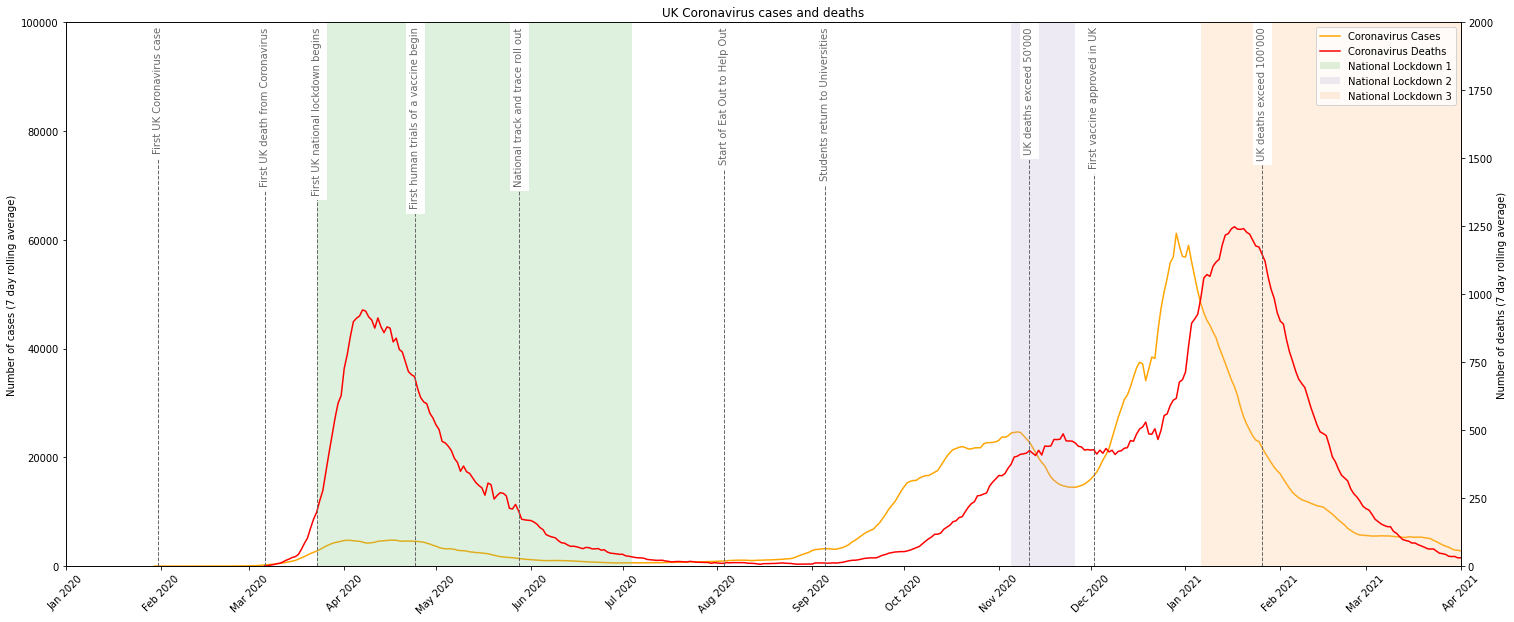

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(x = "date", y = '7DayCases', data = df2, color = 'orange', label = "Coronavirus Cases", legend = False)
plt.xticks(rotation = 45)
ax2 = ax.twinx()
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
sns.lineplot("date", '7DayDeaths', data = df2, color = 'red', label = "Coronavirus Deaths", legend = False)
for d, n , c in zip(dates, names, colours):
  ax2.axvline(x=d, ymax = 0.75, linewidth=1.0, linestyle='--', color = 'dimgray')
  ax2.annotate(n, xy=(d, 1985), horizontalalignment="center", verticalalignment = 'top', color = 'dimgray', backgroundcolor = "white", rotation = 90)
#ax.set_xlabel('X data')
ax.set_ylabel('Number of cases (7 day rolling average)')
# ylabels = ['{}'.format(round(y)) + 'K' for y in g.get_yticks()/1000]
# g.set_yticklabels(ylabels)
ax.set(xlabel=None)
for s, e, n, c in zip(lockdown_start, lockdown_end, lockdown_names, lockdown_colours):
  ax2.axvspan(s, e, facecolor=c, alpha=0.25, label = n)
ax.set(xlim = (dt.datetime.strptime('2020-01-01', "%Y-%m-%d"), dt.datetime.strptime('2021-04-01', "%Y-%m-%d")), ylim = (0, 100000))
ax2.set(ylim = (0, 2000))
ax2.set_ylabel('Number of deaths (7 day rolling average)')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.title('UK Coronavirus cases and deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


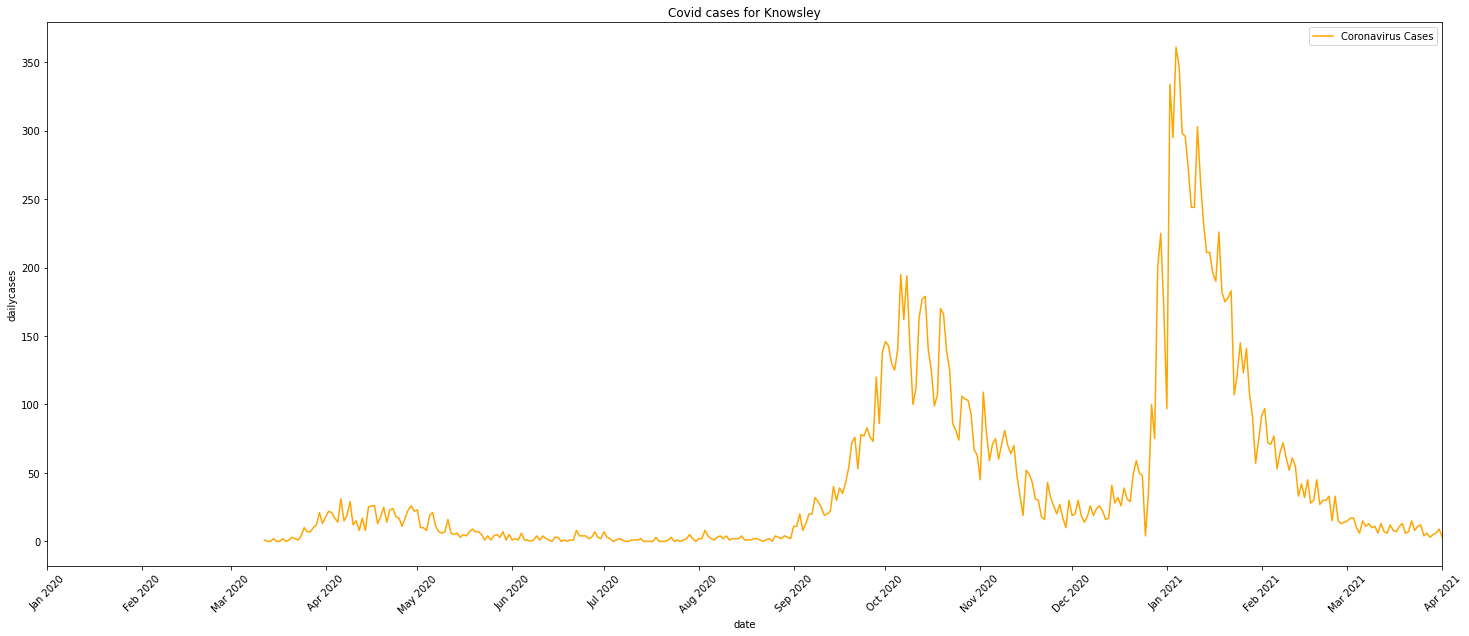

In [ ]:
knowsley = covid[covid["name"]=="Knowsley"].sort_values("date")
avwindow = 7
knowsley["7DayDeaths"] = knowsley["dailydeaths"].rolling(window=avwindow).mean()
knowsley["7DayCases"] = knowsley["dailycases"].rolling(window=avwindow).mean()
knowsley["date"] = pd.to_datetime(knowsley["date"])
ig, ax = plt.subplots(figsize=(25, 10))
# sns.lineplot(x = "date", y = 'dailydeaths', data = knowsley, color = 'orange', label = "Coronavirus Cases", legend = False)
# plt.xticks(rotation = 45)
# ax2 = ax.twinx()
# ax2.xaxis.set_major_locator(mdates.MonthLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
sns.lineplot("date", 'dailycases', data = knowsley, color = 'orange', label = "Coronavirus Cases", legend = True)
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set(xlim = (dt.datetime.strptime('2020-01-01', "%Y-%m-%d"), dt.datetime.strptime('2021-04-01', "%Y-%m-%d")))
plt.title("Covid cases for Knowsley")
plt.show()

In [ ]:
covidint = covidF[covidF['date']<='2021-04-01']

In [ ]:
d0 = date(2020, 1, 30)
d1 = date(2021, 4, 2)
delta = d1 - d0
print(delta.days)

428


In [ ]:
print(len(covidint['date'].unique()))
print(len(covidint['name'].unique()))
print(covidint.describe())
covidint.groupby('name').count().sort_values('name')

428
379
          dailycases  cumulativecases    dailydeaths  cumulativedeaths
count  147953.000000    147953.000000  147953.000000     147953.000000
mean       29.046353      3558.245848       0.565247        108.108075
std        60.981451      6311.201331       1.610999        173.516191
min         0.000000         0.000000       0.000000          0.000000
25%         2.000000       380.000000       0.000000          0.000000
50%         8.000000      1027.000000       0.000000         44.000000
75%        29.000000      4135.000000       0.000000        153.000000
max      1701.000000    100193.000000      45.000000       2646.000000


,date,dailycases,cumulativecases,dailydeaths,cumulativedeaths
name,,,,,
Aberdeen City,394,394,394,394,394
Aberdeenshire,395,395,395,395,395
Adur,379,379,379,379,379
Allerdale,386,386,386,386,386
Amber Valley,386,386,386,386,386
...,...,...,...,...,...
Wychavon,387,387,387,387,387
Wycombe,391,391,391,391,391
Wyre,386,386,386,386,386


Text(0, 0.5, 'Count (log scale)')

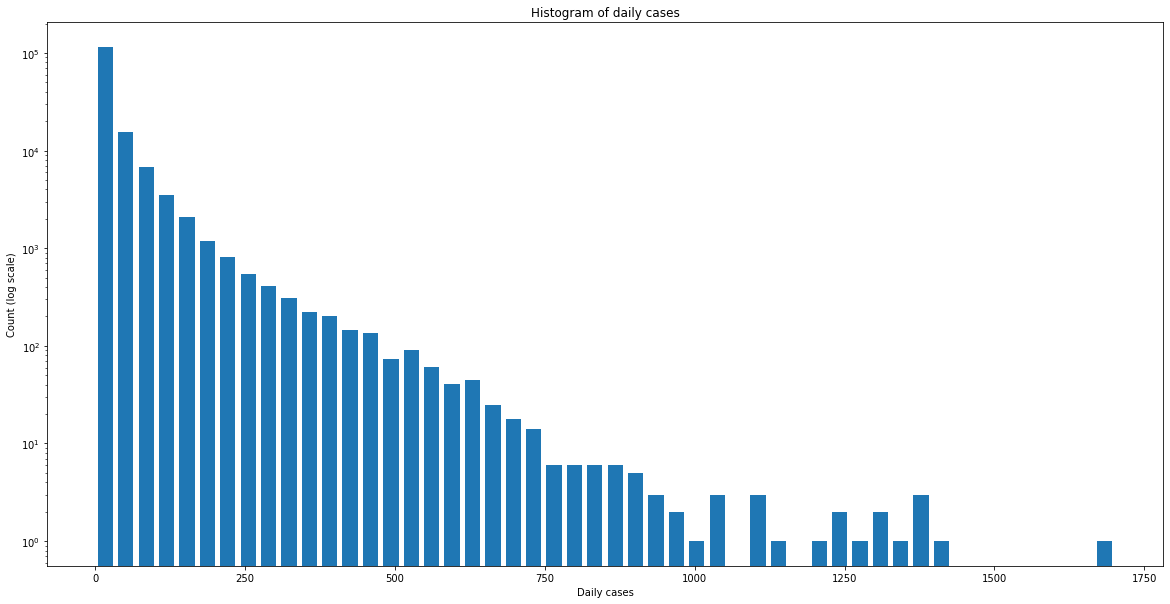

In [435]:
plt.figure(figsize = (20, 10))
plt.hist(covidint['dailycases'], bins = 50, rwidth=0.75)
plt.title("Histogram of daily cases")
plt.xlabel("Daily cases")
plt.yscale('log', nonposy='clip')
plt.ylabel("Count (log scale)")

Text(0, 0.5, 'Count (log scale)')

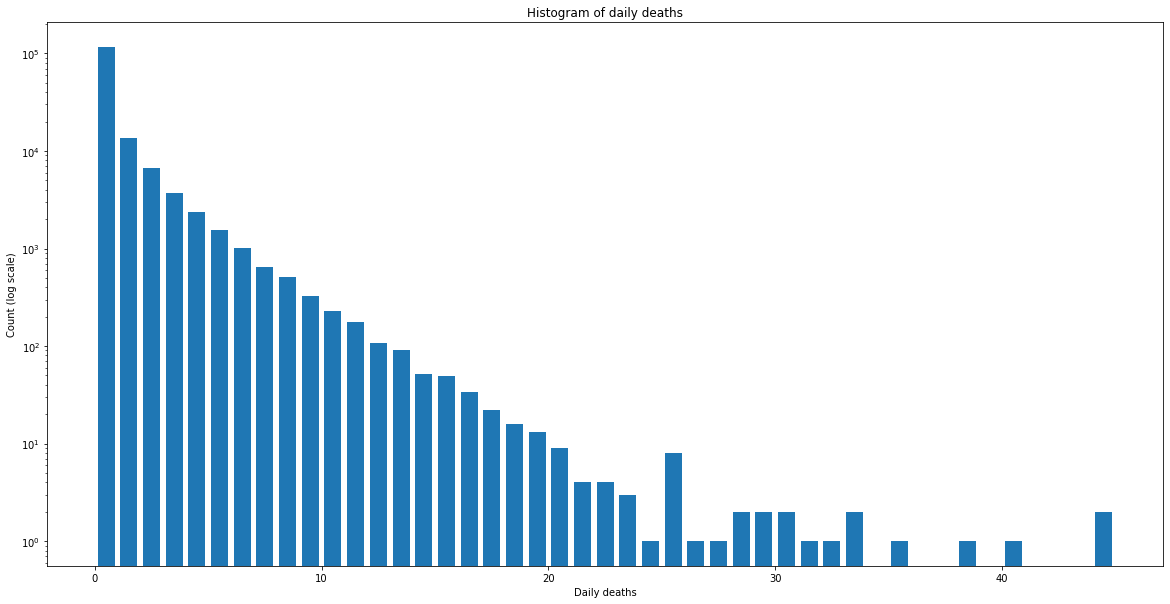

In [434]:
plt.figure(figsize = (20, 10))
plt.hist(covidint['dailydeaths'], bins = 45, rwidth=0.75)
plt.title("Histogram of daily deaths")
plt.xlabel("Daily deaths")
plt.yscale('log', nonposy='clip')
plt.ylabel("Count (log scale)")

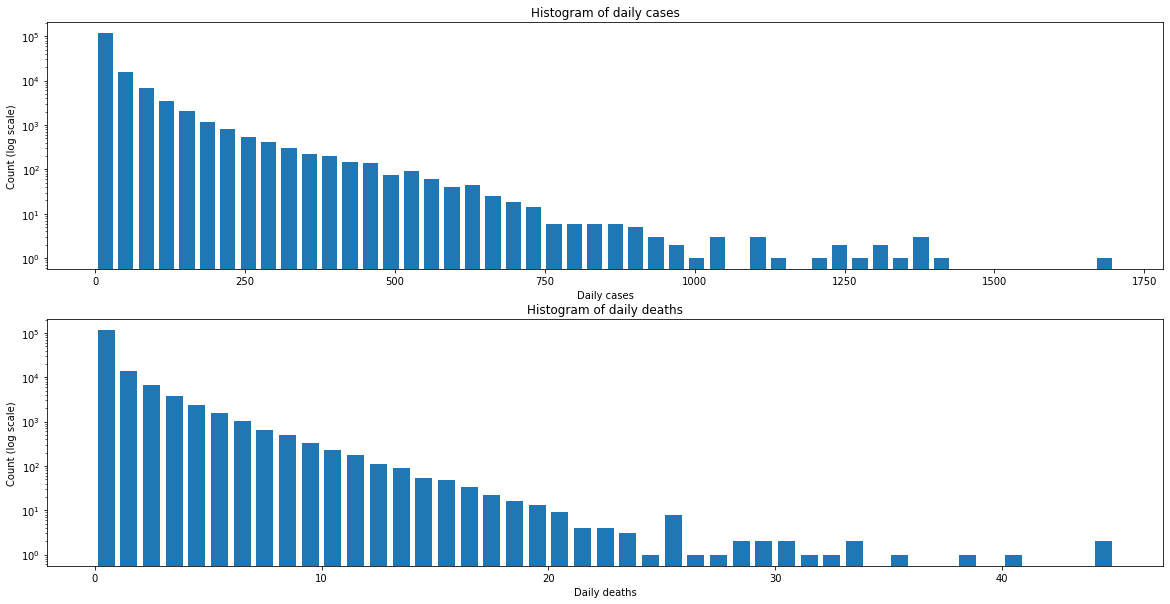

In [456]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax1 = axes[0]
ax2 = axes[1]
ax1.hist(covidint['dailycases'], bins = 50, rwidth=0.75)
ax1.set_title("Histogram of daily cases")
ax1.set_xlabel("Daily cases")
ax1.set_ylabel("Count (log scale)")
ax1.set_yscale('log', nonposy='clip')
ax2.hist(covidint['dailydeaths'], bins = 45, rwidth=0.75)
ax2.set_title("Histogram of daily deaths")
ax2.set_xlabel("Daily deaths")
ax2.set_ylabel("Count (log scale)")
ax2.set_yscale('log', nonposy='clip')

In [ ]:
OD['People'].describe()

count    108546.000000
mean        223.320113
std        2788.358751
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max      256811.000000
Name: People, dtype: float64

In [439]:
odpops[odpops["TravPerc"]>=0.1]['TravPerc'].describe()

count    6892.000000
mean        2.011752
std         4.803354
min         0.100002
25%         0.181357
50%         0.404219
75%         1.314325
max        42.370912
Name: TravPerc, dtype: float64

In [442]:
odpops[odpops["TravPerc"]>=0.1]["TravPerc"]

0          6.826492
3          1.071034
6          3.272966
7          0.100252
8          0.203388
            ...    
108541     0.326248
108542     0.268475
108543     0.514860
108544     0.372126
108545    21.714159
Name: TravPerc, Length: 6892, dtype: float64

Text(0, 0.5, 'Count')

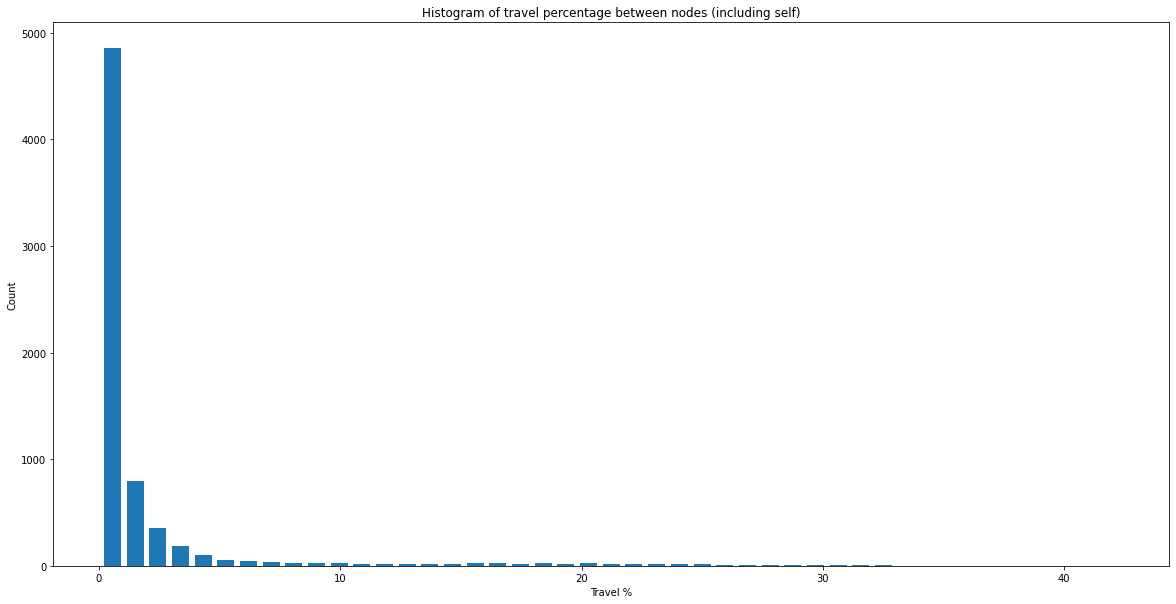

In [444]:
plt.figure(figsize = (20, 10))
plt.hist(odpops[odpops["TravPerc"]>=0.1]["TravPerc"], bins = 45, rwidth=0.75)
plt.title("Histogram of travel percentage between nodes (including self)")
plt.xlabel("Travel %")
plt.ylabel("Count")

In [447]:
popsanddens19

,Name,Pop19,60plusprop,Area (sq km),Pop Density
0,Aberdeen City,228670.0,0.21,186.0,1229.0
1,Aberdeenshire,261210.0,0.26,6313.0,41.0
2,Adur,64301.0,0.29,42.0,1531.0
3,Allerdale,97761.0,0.32,1242.0,79.0
4,Amber Valley,128147.0,0.29,265.0,484.0
...,...,...,...,...,...
374,Wychavon,129433.0,0.32,664.0,195.0
375,Wycombe,174268.0,0.24,325.0,536.0
376,Wyre,112091.0,0.35,282.0,397.0
377,Wyre Forest,101291.0,0.31,195.0,519.0


In [460]:
popsanddens19.columns

Index(['Name', 'Pop19', '60plusprop', 'Area (sq km)', 'Pop Density'], dtype='object')

Text(0, 0.5, 'Count')

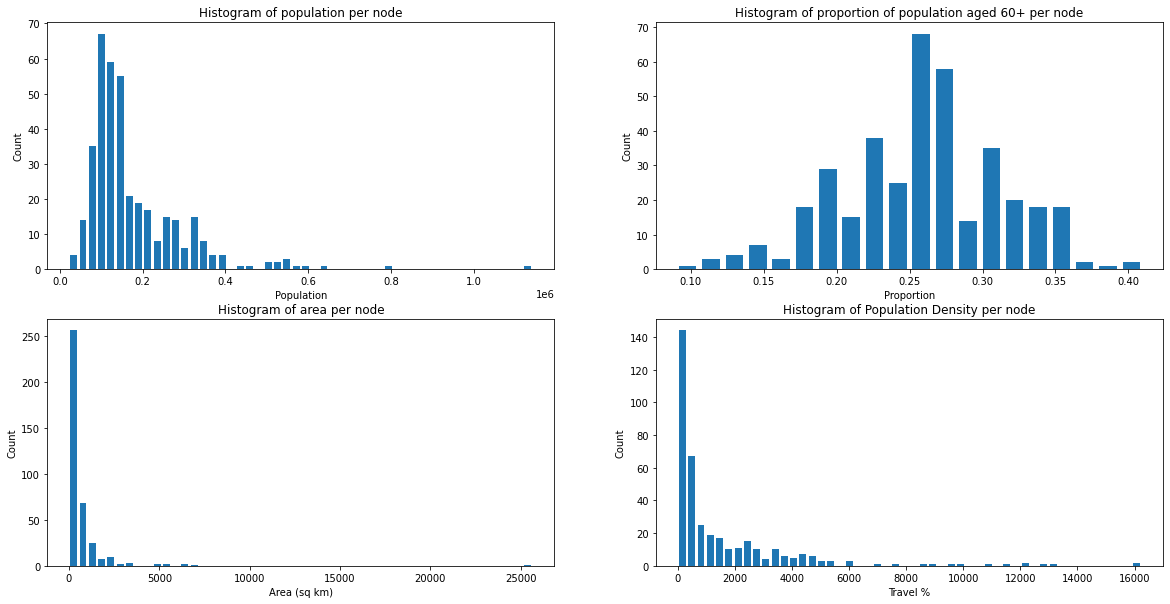

In [463]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
ax1.hist(popsanddens19['Pop19'], bins = 50, rwidth=0.75)
ax1.set_title("Histogram of population per node")
ax1.set_xlabel("Population")
ax1.set_ylabel("Count")
ax2.hist(popsanddens19['60plusprop'], bins = 20, rwidth=0.75)
ax2.set_title("Histogram of proportion of population aged 60+ per node")
ax2.set_xlabel("Proportion")
ax2.set_ylabel("Count")
ax3.hist(popsanddens19['Area (sq km)'], bins = 50, rwidth=0.75)
ax3.set_title("Histogram of area per node")
ax3.set_xlabel("Area (sq km)")
ax3.set_ylabel("Count")
ax4.hist(popsanddens19['Pop Density'], bins = 50, rwidth=0.75)
ax4.set_title("Histogram of Population Density per node")
ax4.set_xlabel("Travel %")
ax4.set_ylabel("Count")

In [ ]:
#create networkx graph
G = nx.Graph()
G = nx.from_pandas_edgelist(nodenums,source='Origin',target='Dest')

 ...]

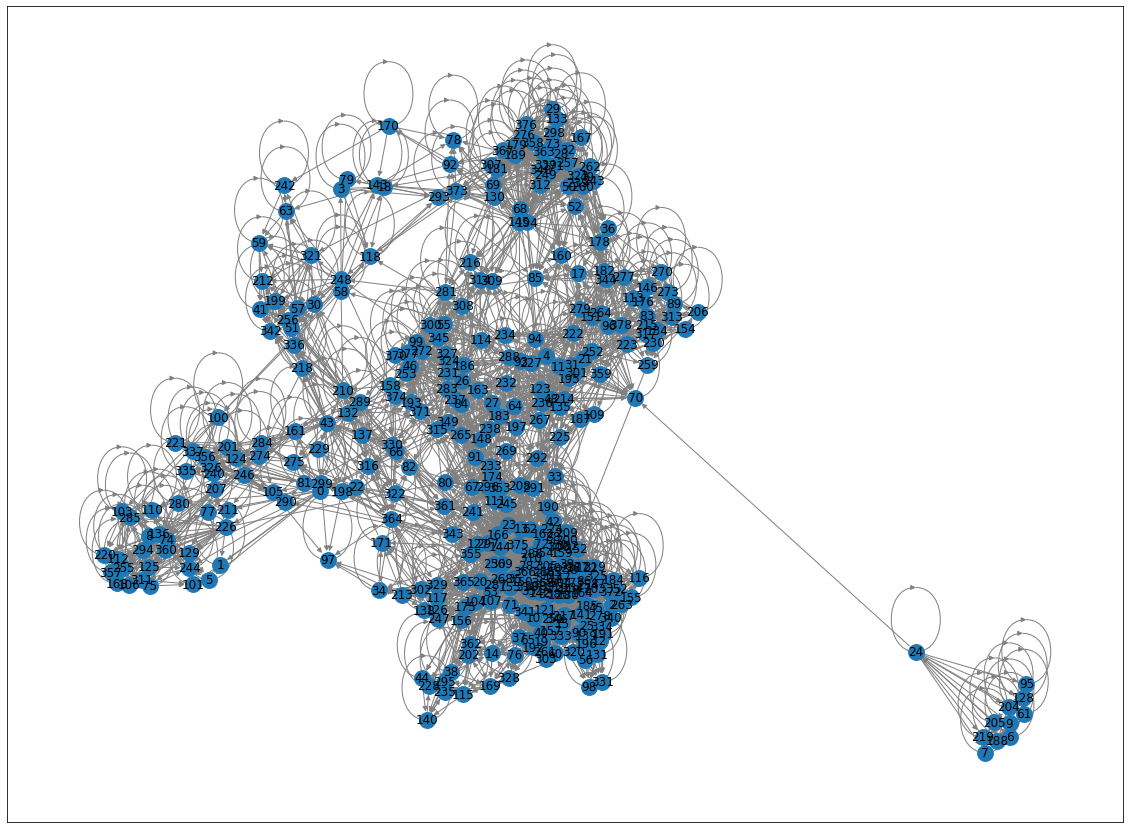

In [ ]:
#plot edges and nodes
plt.figure(figsize = (20, 15))
pos = nx.spring_layout(G)
edge_list = [edge for edge in G.edges()]
nx.draw_networkx_nodes(G,pos, cmap=plt.get_cmap('jet'),node_size = 250)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='gray', arrows=True)
#plt.title("Graph of UK network")

Text(0, 0.5, 'Count of nodes')

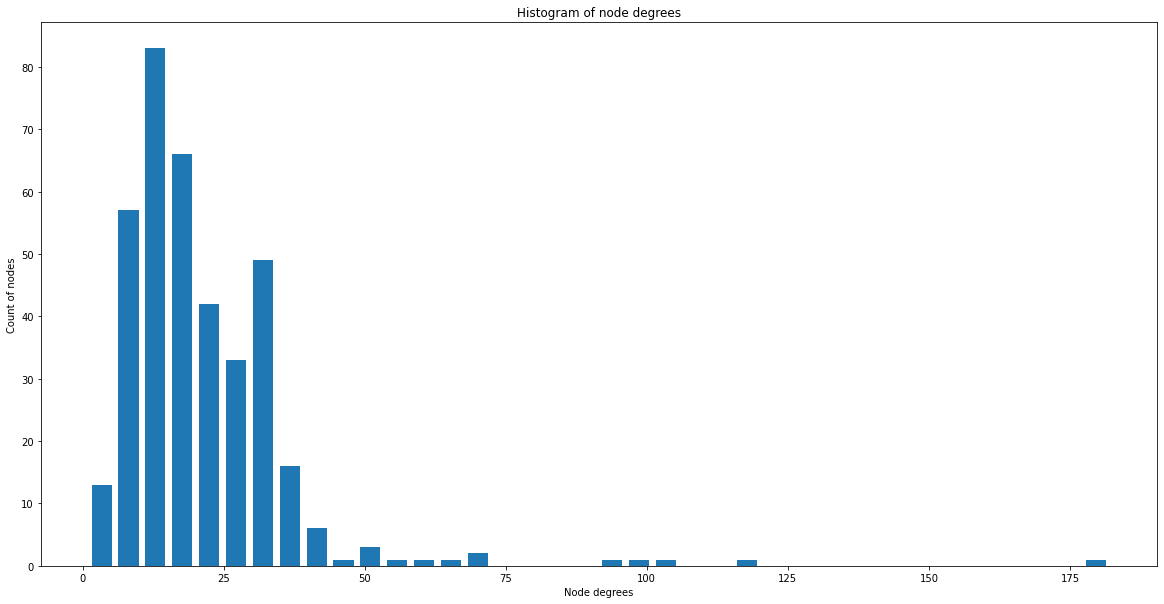

In [470]:
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize = (20, 10))
plt.hist(degrees, bins = 38, rwidth=0.75)
plt.title("Histogram of node degrees")
plt.xlabel("Node degrees")
plt.ylabel("Count of nodes")

In [ ]:
round(sum(degrees)/len(degrees), 1)

23.5

In [466]:
pd.DataFrame(degrees).describe()

,0
count,379.000000
mean,23.525066
std,16.280812
min,3.000000
25%,14.000000
50%,20.000000
75%,29.500000
max,184.000000


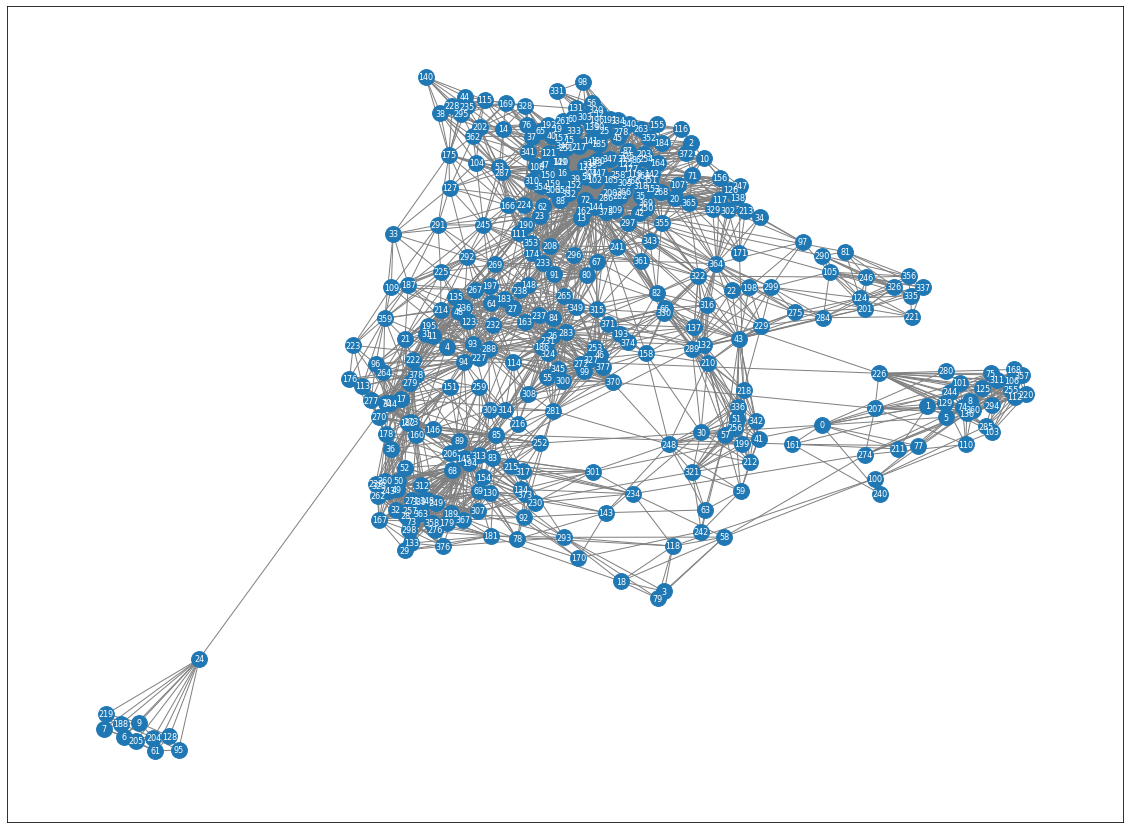

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))
#plot edges and nodes
plt.figure(figsize = (20, 15))
pos = nx.spring_layout(G)
edge_list = [edge for edge in G.edges()]
nx.draw_networkx_nodes(G,pos, cmap=plt.get_cmap('jet'),node_size = 250)
nx.draw_networkx_labels(G, pos, font_size=8, font_color = 'white')
nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='gray', arrows=False)
#plt.title("Graph of UK network")